# DEEP LEARNING - PRACTICUM 03

- Diego Roca Rodríguez
- Roi Santos Ríos

Wasserstein Generative Adversarial Networks, with Gradient Penalty (WGAN-GP)

# Theory

### DCGAN

Generative Adversial Networks are a architecture of Deep Learning systems where we train two different models (a discriminator $D$ and a generator $G$) with the goal of generating data similar to the one present in the training dataset. 

Compared to the <b>Variational Auto Encoders</b> the <b>GANs</b> have the following differences:
- VAEs attempt to make their generated data distribution match the original data distribution (or, in formal words, reduce the bound on the sets divergence). GANs try to make their generated data distribution seem 'real' by playing a min-max game between a discriminator and a generator (or, in formal words, minimize the divergence of the generated set from an unknown set).
- While VAEs need to know the original data distribution GANs do not!
- VAEs generate a pair of encoder/decoder, GANs only generate the decoder.

During the training, $G$ will generate the samples from random noise $z$, therefore making the generated samples be considered $G(z)$. Training a GAN usually consists in a mini-max game where $G$ and $D$ compete to get the better results, $D$ by attempting to discriminate the items that $G$ produce from the real ones and $G$ by attempting to trick $D$. On the other hand, the generator will take as an input the real images $X$ and the output of the generator $G(z)$, therefore making its output $D(X,G(z))$.

The training for the GANs will be performed in separate training loops, first training the generator and after that training the discriminator. This allows for a GAN to first generate false data and later learn to discriminate it. 

As we have two models, we will have two loss functions in this architecture, both generated by the discriminator. The discriminator loss will be the one employed by $D$; the generator loss will be the one employed by $G$. Both models have opposite interests is hard to find a function $V(G,D)$ to minimize during training, where $V(G,D)$ is defined as follows:

  $ V(G,D) = E_x * log(D(X)) + E_z * log(1-D(G(z))) $

So, during the training, how we deal with this min-max optimization? The idea is to tweak the discriminator:

- Undertrained discriminator (too bad): give incorrect information to the generator
- Overtrained discriminator (too good): the generator cant do shit to escape this situation

So, how do we tweak it?
- Dropout layers
- Reduce learning rate
- Reduce discriminator CNN layer
- Add noise to images or to labels (change some trues to false)

And, what happens when the generator becomes extremely good at its work (or the discriminator gets very bad)? Well, this problem is what is called the mode collapse and causes the generator to:

- Generator will generate a set of very similar images that the generator will have no choice but accept
- Generator will point all inputs to a given point in the latent space that the generator 'likes'

This mode collapse can come in two flavours: <b>intraclass</b>, when all elements generated from a given class are equal and <b>interclass</b> when all generated elements are 'correct' but are equal regardless of the class. In the latent space this can be seen in the shape of gradients between locations of given instances (e.g. for the number detection problem instead of having a 'unique' section for the 7 and another for the 6 we would have a big gradiented section).



So, as we can see, $D$ wants to make the $D(X)=1$ and $D(G(z))=0$ while $G$ wants the opposite. This may cause a problem when the generator becomes good enough that the discriminator will start to give random outputs or where the discriminator becomes 'invincible'. This can be avoided thanks to 
- Gradient penality
- Lipchitz constraint
- <b>Wasserstein loss function</b>

### WGAN

The Wasserstein loss functions allows us to tweak GANs into W-GANs that will solve this problem. This loss function works by <b> computing the work necessary to transform a probability distribution into another </b>, therefore, getting its value reduced when the distributions are similar. In the context of GANs, the discriminator wants to make $W$ grow while $G$ wants it to get to 0. So... how does this change from the previous loss function based on crossentropy?
- There is no fixed threshold for when an instance is real or generated (e.g. a instance is real when v>0.5 is no longer true!)
- The output therefore <b> is a number, not a 'truth value' </b>
- The discriminator $D$ is no longer a discriminator, is a critic that attempts to 'predict' the Wasserstein distance between two sets of images.$C$

So.. what consecuences does this loss function has in relation to basic GANs?
- The images generated are sharper
- As loss function decreases, the image quality rises
- Avoids mode collapse (the GAN will always attempt to decrease the value of the loss, not getting stuck at any point where the generator thinks that is work is 'good enough')
- The last layer of the critic $C$ model MUST NOT have a sigmoid layer, as we want the 'raw' loss value

As we no longer have the problem of vanishing gradients, WGANs will no longer need to perform label smoothing (turing true to false labels) or have a big dropout in comparison to GAN. Another advantage of having the discriminator turn into a critic comes with the lack of need of training the generator first, thus changing the training process into:

1. Train $C$ to compute distance between random noise and real images inside the latent space
2. Train $G$ to generate images from random noise that makes the outputs of $C$ be as small as possible
3. If the value of $C(G(z))$ is not good enough, repeat

However, how can we assure that the discriminator does not output very big distances (i.e. constraining its output?); well, what we do is employ the lipschitz constraint where we 'limit' the explosion of erratic behaviour of the discriminator. This comes with a problem though, as when we limit the output of a function we may fall into vanishing gradients problem.

A remark to make when building the critic is that we will not employ batch normalization layers, as they will create correlation between images in the same batch and that is not always true (almost never is true).

The code for our generator will fulfill the same function as the decoder in a variational-auto-encoder. Will take elements from the latent space and try to reconstruct an image from our 'real' sepace. The input will be a single vector representing a point in latent space (len(v)=ZDIM). After that we will pass it through inverse convolutionals that will increase its dimensionality and end with a tanh function to restore the original image.

### WGAN-GP

So, how do we deal with this? Enter the WGAN with Gradient Penaltiy (WGAN-GP). This improvement over GANs allow for getting rid of Lipschitz constraint and replace it with a gradient penaltiy (i.e. a derivative penalty) that allows for the function to be constrained without falling into vanishing gradients.

The gradient penaltiy will be computed using the critic's output for the 'gradient' (interpolatd) image between the real and generated images. This new factor will be added to the loss function making it smoother.


## Imports

In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy import iscomplexobj
from scipy.linalg import sqrtm

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers
import tensorflow_hub as hub

import matplotlib.pyplot as plt

import glob

#from utils import display, sample_batch, display_one, display_list

## Auxiliar functions

In [9]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

def sample_batch_from_dataset(dataset, n=1):
    batch = dataset.take(n)
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

def display_one(image, cmap="gray"):
    if image.max() > 1.0:
        image = image / 255.0
    elif image.min() < 0.0:
        image = (image + 1.0) / 2.0
        
    plt.imshow(image.astype("float32"), cmap=cmap)
    plt.axis("off")
    plt.show()
    
def display_list(images_list, cmap="gray"):
    """
    Displays n random images from each one of the supplied arrays.
    """
    for images in images_list:
        if images.max() > 1.0:
            images = images / 255.0
        elif images.min() < 0.0:
            images = (images + 1.0) / 2.0
    
    plt.figure(figsize=(20, 3))
    for i in range(len(images_list)):
        _ = plt.subplot(1, 10, i + 1)
        plt.imshow(images_list[i].astype('uint8'), cmap=cmap)
        plt.axis("off")

    plt.show()

## 0. Parameters <a name="parameters"></a>

For the hyperparameter optimization, instead of performing an automated grid search to find the parameters that yield the best metrics, we decided to perform a manual search, by tweaking the parameters one by one and observing the resulting metrics and images by hand. As this is a really time-consuming task, we've decided to limit the search to the following hyperparameters and values:

- BATCH_SIZE = [64, 128, 256] and STEPS_PER EPOCH = [3165, 1582, 792] to match the dataset size and use it as a whole each epoch.

- Z_DIM = [64, 128, 256]

- NUM_FEATURES = [64, 128, 256]

- CRITIC_STEPS = [1, 3, 5]

We focused more on the images produced, taking the metrics as a sort of tie-breaker.

We started by changing the batch size.

- batch 64 ->
- batch 128 -> 
- batch 256 -> c_acc: 64.75 - g_acc: 38.54

Then, using that 256 batch size, we evaluated the three values of the latent space size. We chose to continue with z = 256

- z 64 -> c_acc: 50.32 - g_acc: 51.24
- z 256 -> c_acc: 46.77 - g_acc: 66.24

Later, we changed the number of features and 256 proved to be the better value taking the images into account.

- numfeats 64 -> c_acc: 65.0904 - g_acc: 39.166
- numfeats 256 -> c_acc: 73.1208 - g_acc: 30.4786

Finally, we evaluated the model using different amounts of critical steps. We chose to use 5.

- cstep 1 -> c_acc: 75.34 - g_acc: 27.45
- cstep 5 -> c_acc: 45.7832 - g_acc: 59.1775

The images outputted by the model with every change are saved in the "wganParamsEvolution" folder.

In the following code block we have the parameters that we deemed "best", taking into account the computational constraints
that we are limited to.

In [10]:
IMAGE_SIZE = 32
CHANNELS = 3

BATCH_SIZE = 256
NUM_FEATURES = 256
Z_DIM = 256


EPOCHS = 10
STEPS_PER_EPOCH = 792


LEARNING_RATE = 0.0002
CRITIC_STEPS = 5

ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999

GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5


DATA_PATH = "./train/img_align_celeba"

In [11]:
# Load the data
train_data = utils.image_dataset_from_directory(
    DATA_PATH,
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

# Repeat the dataset
#train_data = train_data.repeat()

Found 202599 files belonging to 1 classes.


In [12]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    
    return img


train = train_data.map(lambda x: preprocess(x))

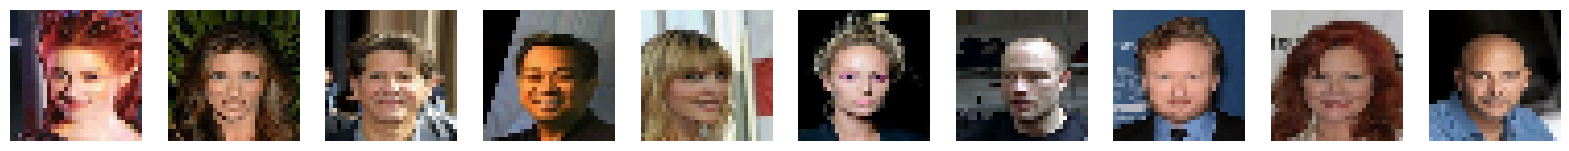

In [13]:
# Show some faces from the training set
train_sample = sample_batch(train)

display(train_sample, cmap="Spectral")

In [14]:
# Load the pre-trained Inception v3 model
inception_v3 = hub.KerasLayer('https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5', input_shape=(299, 299, 3))

## 2. Build the WGAN-GP <a name="build"></a>

Regarding the modifications to the network, the ones proposed in class are the following:

- Adding more convolutional layers and increasing the model's depth
- Incorporating a residual connection
- Employing dilated convolutions

Dilated convolutions proved to be the most time consuming improvement. We changed the first convolutional layer from:

``` x = Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input) ```

To:

``` x = Conv2D(64, kernel_size=4, strides=1, padding="same", dilation_rate=2)(critic_input) ```

And the training time per epoch skyrocketed from 3 minutes to around 15, with just using dilation in ONE layer.
Thus we scrapped this approach, and decided to focus on the other two.

We finally decided to implement residual connections, to improve the flow of gradients, coupled with doubling the
number of parameters for the Convolutional and Transposed Convolutional layers. This also increased the training
time, from 3 minutes to around 10, but this is a more resonable increase, all things considered.

The following code blocks include the residual connections and increased parameters.

In [15]:
def residual_block(x, filters, kernel_size=2, strides=2, dropout=0.3):
    residual = x
    x = layers.Conv2D(filters, kernel_size, strides, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    residual = layers.Conv2D(filters, kernel_size, strides, padding="same")(residual)
    x = layers.add([x, residual])
    x = layers.Dropout(dropout)(x)
    
    return x

critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)

x = residual_block(x, 256)
x = residual_block(x, 512)

x = layers.Conv2D(1, kernel_size=2, strides=1, padding="valid")(x)

critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)

critic.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 128)  6272        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 16, 128)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 256)    131328      ['leaky_re_lu[0][0]']            
                                                                                              

In [16]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)

x = layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh")(x)

generator = models.Model(generator_input, generator_output)

generator.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        2097152   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097

In [17]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_metric, self.c_wass_loss_metric, self.c_gp_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

      # Calculate Critic and Generator Accuracy
        c_acc = tf.reduce_mean(tf.cast(tf.math.greater(real_predictions, 0), tf.float32)) * 100
        g_acc = tf.reduce_mean(tf.cast(tf.math.less(fake_predictions, 0), tf.float32)) * 100

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        #return {m.name: m.result() for m in self.metrics,'c_acc': c_acc,'g_acc': g_acc}    
        return {**{m.name: m.result() for m in self.metrics}, 'c_acc': c_acc, 'g_acc': g_acc}
    

In [18]:
# Create a GAN
wgangp = WGANGP(critic=critic, generator=generator, latent_dim=Z_DIM, critic_steps=CRITIC_STEPS, gp_weight=GP_WEIGHT)

In [19]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

## 3. Callbacks and FID calculation <a name="fid"></a>

In [20]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to="./output/generated_img_%03d.png" % (epoch), cmap=None)

In [ ]:
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {
            'c_loss': [],
            'g_loss': [],
            'c_acc': [],
            'g_acc': [],
        }

    def on_epoch_end(self, epoch, logs=None):
        self.history['c_loss'].append(logs['c_loss'])
        self.history['g_loss'].append(logs['g_loss'])
        self.history['c_acc'].append(logs['c_acc'])
        self.history['g_acc'].append(logs['g_acc'])

The Fréchet Inception Distance is an evaluation metric used to assess the quality and diversity of generated images in generative models.
FID compares the statistics of feature representations extracted from real images and generated images using an Inception model.

The Inception model used requires a minimum image size of 70x70, but we chose to use 299x299 instead, so we have to upscale the images to
accomodate for this.

To be able to see the evolution of the FID throughout the training process, we've decided to implement a new callback class.
This class, at the end of each training epoch, performs the following:

- Calls the WGAN's generator to create 10 images using randomized feature vectors.
- Preprocesses the generated images for the inception model, and then evaluates them.
- Loads 10 random real images from the dataset.
- Preprocesses the real images for the inception model, and then evaluates them.
- Calculates the FID using the (real and generated) features that the inception model outputs.

It also displays the real and generated images onscreen, as to be able to visually compare the model's performance.

In [21]:
class CalculateFid(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    # Define a function to calculate FID
    def calculate_fid(self, real_features, generated_features):
        # Calculate the mean and covariance of the real and generated features
        mu_real = np.mean(real_features, axis=0)
        mu_generated = np.mean(generated_features, axis=0)
        cov_real = np.cov(real_features, rowvar=False)
        cov_generated = np.cov(generated_features, rowvar=False)

        # Calculate the squared difference between the means
        diff = mu_real - mu_generated
        diff_squared = np.dot(diff, diff)

        # Calculate the square root of the product of the covariances
        cov_sqrt = sqrtm(cov_real.dot(cov_generated))
        
        if iscomplexobj(cov_sqrt):
            cov_sqrt = cov_sqrt.real

        # Calculate the FID
        fid = diff_squared + np.trace(cov_real + cov_generated - 2 * cov_sqrt)

        return fid

    def preprocess_inception(self, image):
        image = tf.image.resize(image, (299, 299))
        image = tf.keras.applications.inception_v3.preprocess_input(image)
        return image
    
    def on_epoch_end(self, epoch, logs=None):
        z_sample = np.random.normal(size=(self.num_img, Z_DIM))

        # Generate a batch of images using the model
        generated_images = wgangp.generator.predict(z_sample)

        # Preprocess the images
        prepd_gen_images = np.array([self.preprocess_inception(image) for image in generated_images])

        # Extract features from the images
        generated_features = inception_v3(prepd_gen_images)
        generated_features = tf.keras.backend.eval(generated_features)

        print("GENERATED IMAGES, EPOCH: ", epoch)
        display(generated_images, cmap="Spectral")
        
        #Load 10 images at random
        real_images = np.array([tf.keras.preprocessing.image.img_to_array(
            tf.keras.preprocessing.image.load_img(image_path, target_size=(32, 32)))
                                for image_path in np.random.choice(
                                    glob.glob("./train/img_align_celeba/img_align_celeba/*.jpg"), self.num_img)])
        
        # Preprocess the images
        prepd_real_images = np.array([self.preprocess_inception(image) for image in real_images])

        # Extract features from the images
        real_features = inception_v3(prepd_real_images)
        real_features = tf.keras.backend.eval(real_features)

        #print(real_features.shape)
        print("REAL IMAGES, EPOCH: ", epoch)
        display_list(real_images, cmap="Spectral")
        
        # Calculate the FID
        fid = self.calculate_fid(real_features, generated_features)
        print("-------------------------")
        print("EPOCH: ", epoch, " FID: ", fid)

In [ ]:
loss_history = LossHistory()
calculate_fid = CalculateFid(num_img=10, latent_dim=Z_DIM)

## 4. Train the GAN <a name="train"></a>

Epoch 1/10
1/1 [==============================] - 0s 309ms/step
GENERATED IMAGES, EPOCH:  0


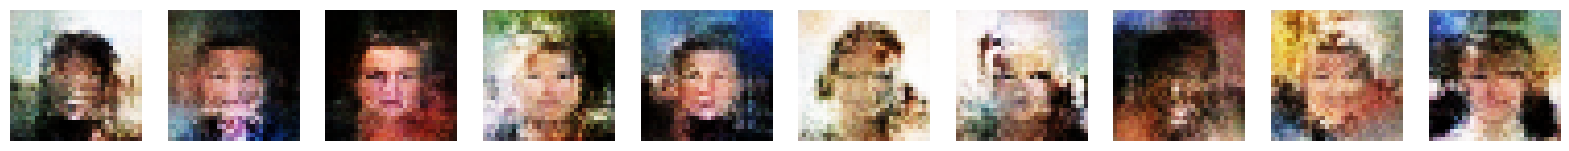

REAL IMAGES, EPOCH:  0


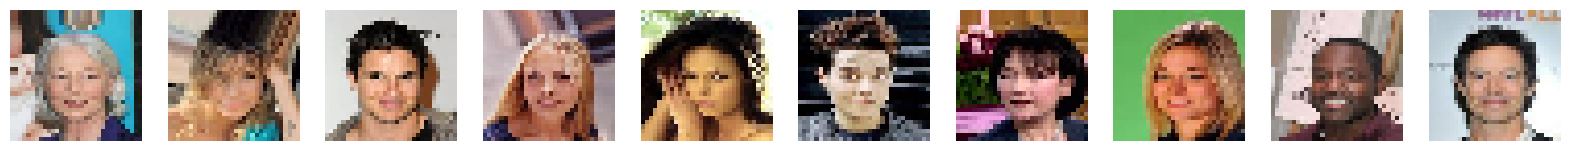

-------------------------
EPOCH:  0  FID:  731.158271177886
792/792 [==============================] - 701s 855ms/step - c_loss: -0.5045 - c_wass_loss: -0.5303 - c_gp: 0.0026 - g_loss: 0.0849 - c_acc: 73.8774 - g_acc: 54.8862
Epoch 2/10
1/1 [==============================] - 0s 22ms/step
GENERATED IMAGES, EPOCH:  1


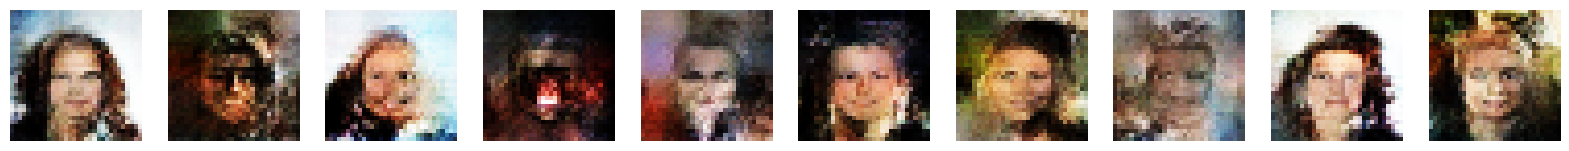

REAL IMAGES, EPOCH:  1


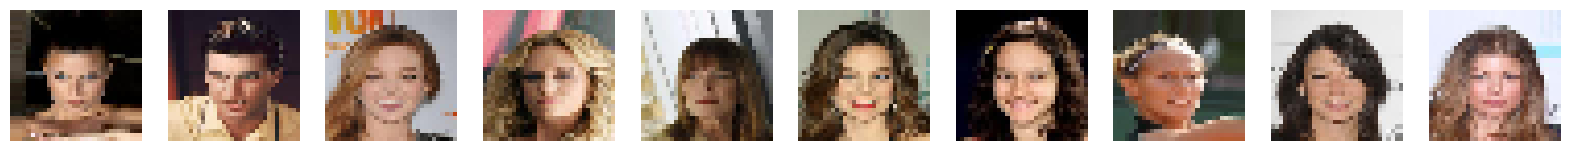

-------------------------
EPOCH:  1  FID:  672.3541518352399
792/792 [==============================] - 675s 852ms/step - c_loss: -0.3291 - c_wass_loss: -0.3492 - c_gp: 0.0020 - g_loss: 0.2270 - c_acc: 59.0537 - g_acc: 65.4523
Epoch 3/10
1/1 [==============================] - 0s 19ms/step
GENERATED IMAGES, EPOCH:  2


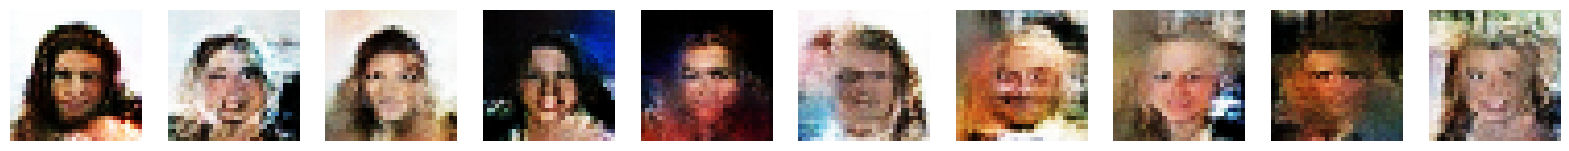

REAL IMAGES, EPOCH:  2


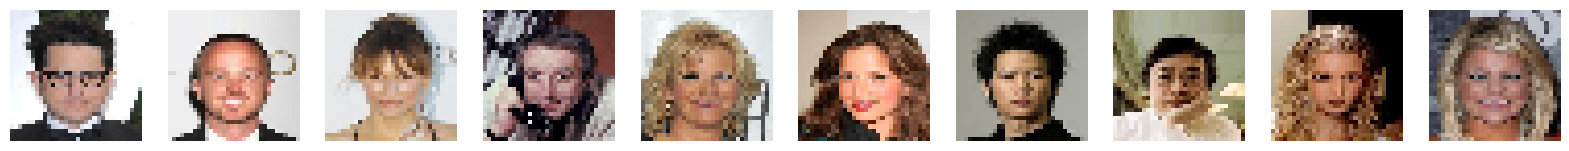

-------------------------
EPOCH:  2  FID:  765.4522144141184
792/792 [==============================] - 674s 851ms/step - c_loss: -0.2935 - c_wass_loss: -0.3119 - c_gp: 0.0018 - g_loss: 0.1800 - c_acc: 60.5726 - g_acc: 62.0132
Epoch 4/10
1/1 [==============================] - 0s 28ms/step
GENERATED IMAGES, EPOCH:  3


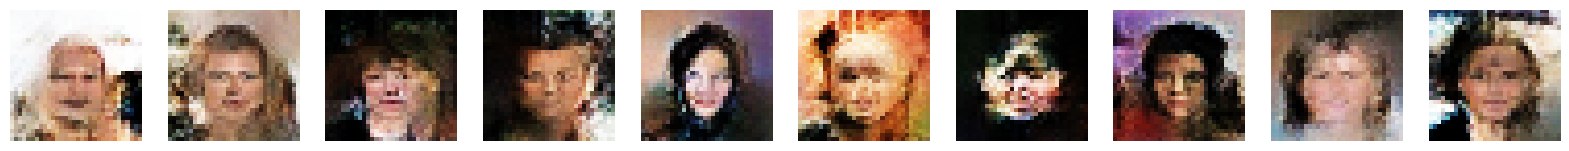

REAL IMAGES, EPOCH:  3


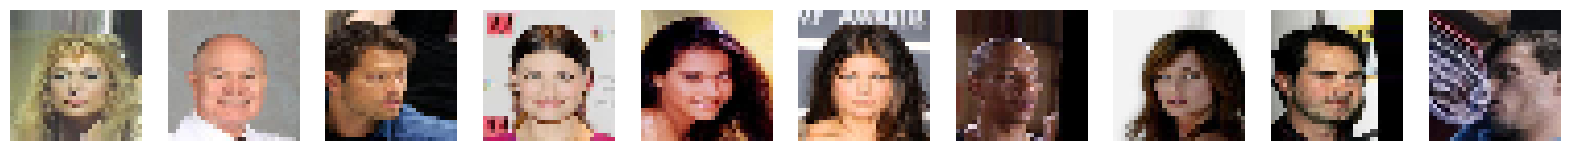

-------------------------
EPOCH:  3  FID:  667.3120323011756
792/792 [==============================] - 674s 850ms/step - c_loss: -0.2622 - c_wass_loss: -0.2793 - c_gp: 0.0017 - g_loss: 0.1435 - c_acc: 60.7072 - g_acc: 59.4299
Epoch 5/10
1/1 [==============================] - 0s 20ms/step
GENERATED IMAGES, EPOCH:  4


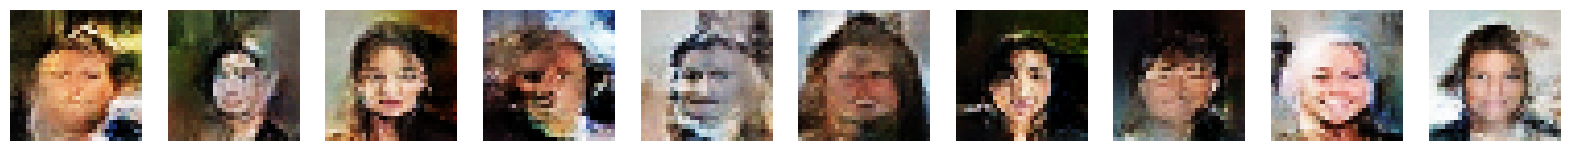

REAL IMAGES, EPOCH:  4


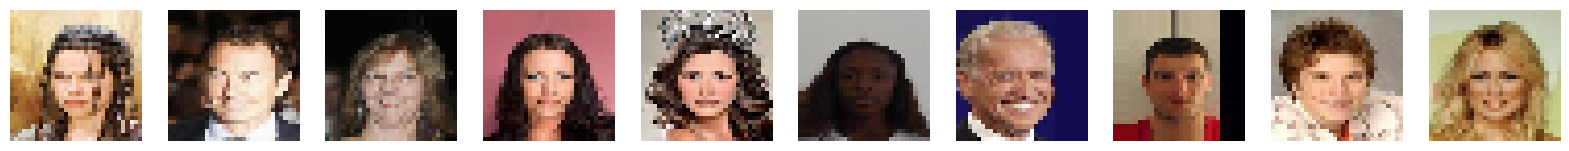

-------------------------
EPOCH:  4  FID:  666.8715104769084
792/792 [==============================] - 675s 851ms/step - c_loss: -0.2457 - c_wass_loss: -0.2623 - c_gp: 0.0017 - g_loss: 0.1291 - c_acc: 60.8655 - g_acc: 58.7455
Epoch 6/10
1/1 [==============================] - 0s 18ms/step
GENERATED IMAGES, EPOCH:  5


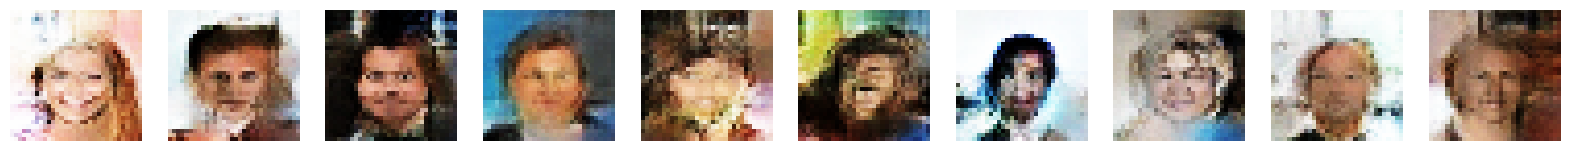

REAL IMAGES, EPOCH:  5


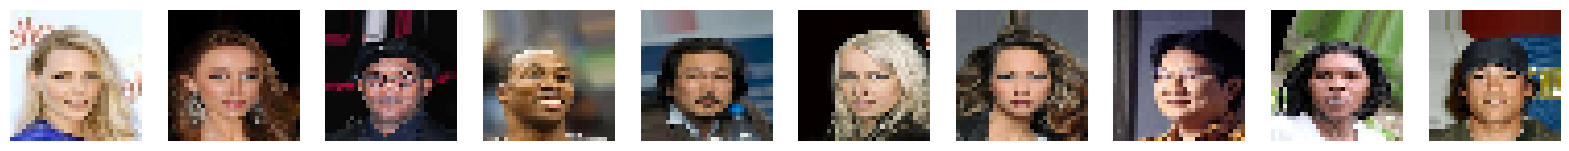

-------------------------
EPOCH:  5  FID:  627.3600607081553
792/792 [==============================] - 675s 851ms/step - c_loss: -0.2323 - c_wass_loss: -0.2484 - c_gp: 0.0016 - g_loss: 0.1267 - c_acc: 59.5607 - g_acc: 59.1110
Epoch 7/10
1/1 [==============================] - 0s 24ms/step
GENERATED IMAGES, EPOCH:  6


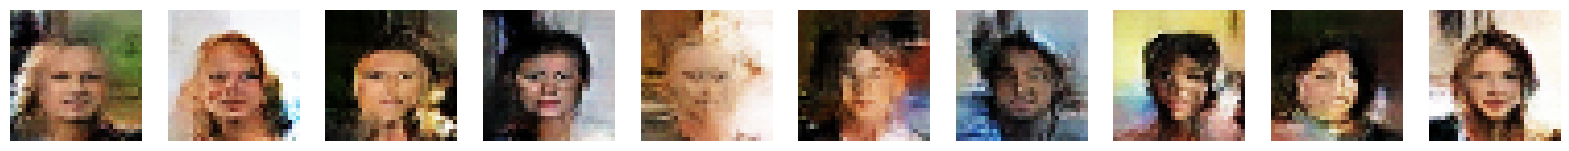

REAL IMAGES, EPOCH:  6


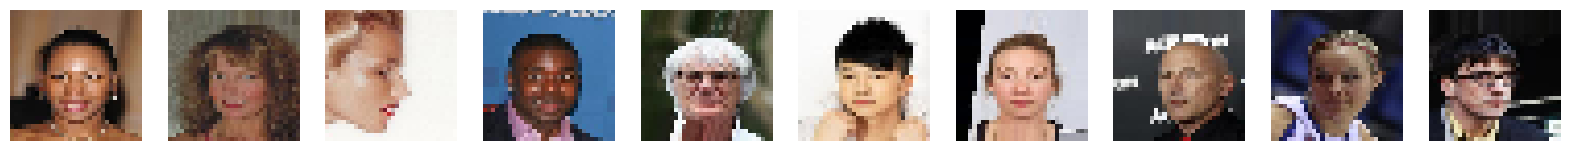

-------------------------
EPOCH:  6  FID:  674.3227157566077
792/792 [==============================] - 675s 851ms/step - c_loss: -0.2208 - c_wass_loss: -0.2363 - c_gp: 0.0016 - g_loss: 0.1186 - c_acc: 59.5795 - g_acc: 58.1513
Epoch 8/10
1/1 [==============================] - 0s 18ms/step
GENERATED IMAGES, EPOCH:  7


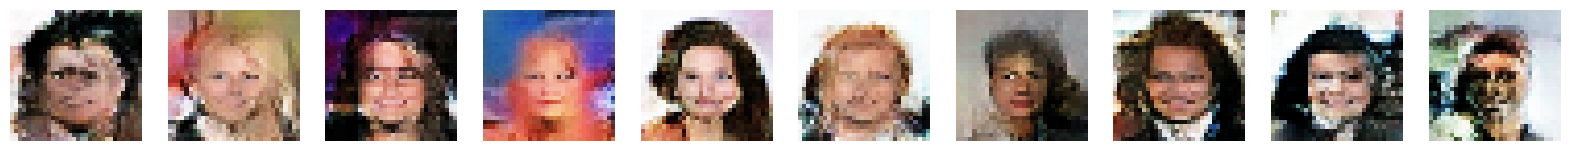

REAL IMAGES, EPOCH:  7


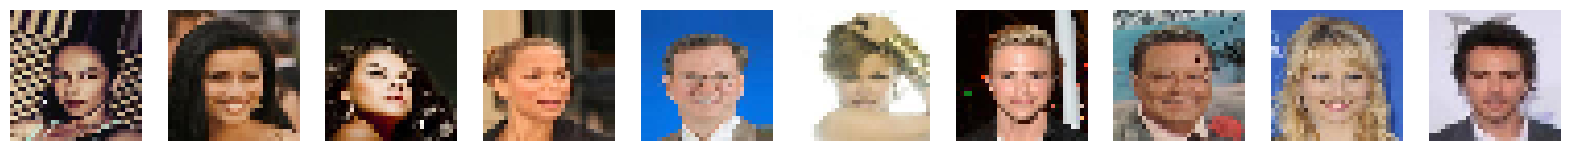

-------------------------
EPOCH:  7  FID:  736.75695011749
792/792 [==============================] - 674s 851ms/step - c_loss: -0.2091 - c_wass_loss: -0.2245 - c_gp: 0.0015 - g_loss: 0.0984 - c_acc: 60.1404 - g_acc: 56.9065
Epoch 9/10
1/1 [==============================] - 0s 20ms/step
GENERATED IMAGES, EPOCH:  8


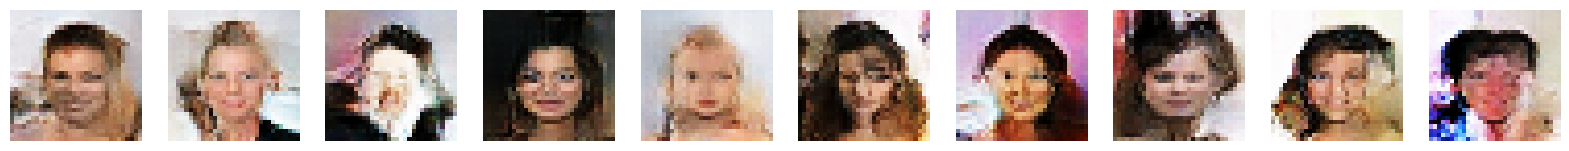

REAL IMAGES, EPOCH:  8


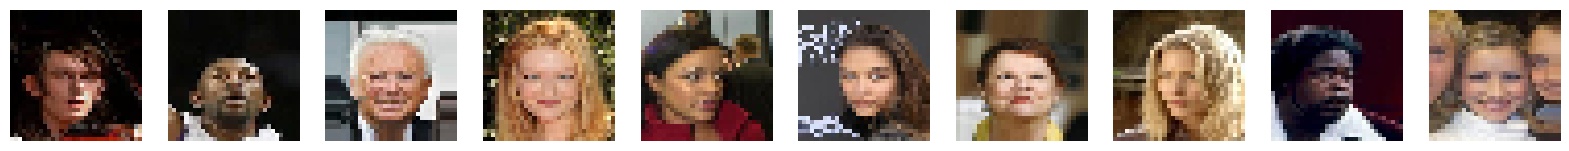

-------------------------
EPOCH:  8  FID:  588.70069936282
792/792 [==============================] - 674s 850ms/step - c_loss: -0.1987 - c_wass_loss: -0.2143 - c_gp: 0.0016 - g_loss: 0.0852 - c_acc: 60.4030 - g_acc: 55.6059
Epoch 10/10
1/1 [==============================] - 0s 20ms/step
GENERATED IMAGES, EPOCH:  9


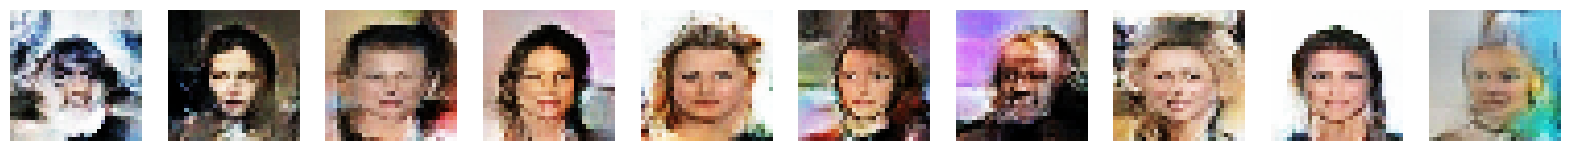

REAL IMAGES, EPOCH:  9


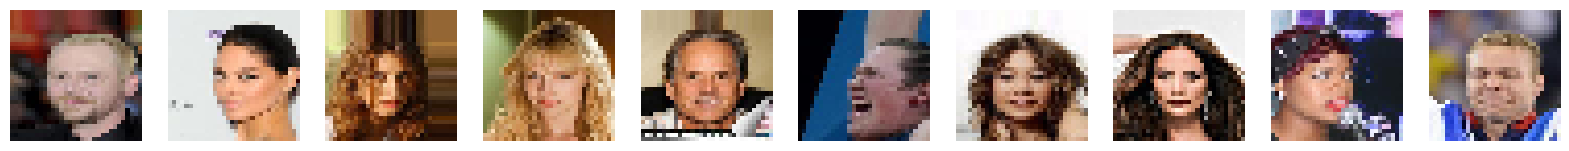

-------------------------
EPOCH:  9  FID:  718.7711925848887
792/792 [==============================] - 674s 851ms/step - c_loss: -0.1925 - c_wass_loss: -0.2076 - c_gp: 0.0015 - g_loss: 0.0804 - c_acc: 59.7526 - g_acc: 55.1684


In [22]:
wgangp.fit(
    train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[model_checkpoint_callback, tensorboard_callback, calculate_fid, loss_history],
)

In [23]:
# Save the final models
generator.save("./models/generator")
critic.save("./models/critic")

# 5. Results

As we can see in the previous code block, in each epoch we print 10 images generated by the network, alongside 10 randomly chosen images from the dataset.
The quality of the generated images is, to say the least, dubious. In the last epoch, we could consider that 5 out of 10 images are pretty good for 32x32 resolution,
while the others have server problems.

The outputted accuracies of the generator and critic are around the same, which is a good balance to strike.

The FID values are around 500 - 700, with the 9th epoch (number 8 as they started counting from 0) having the lowest with 588. We would argue that the images of
the last epoch are more "realistic" than the ones in the 9th, despite the fact that the FID is lower. The FID only provides a quantitative measure of the similarity between the feature distributions of real and generated images. While FID is commonly used as an evaluation metric for these models, it doesn't fully capture the notion of "realism" on its own.

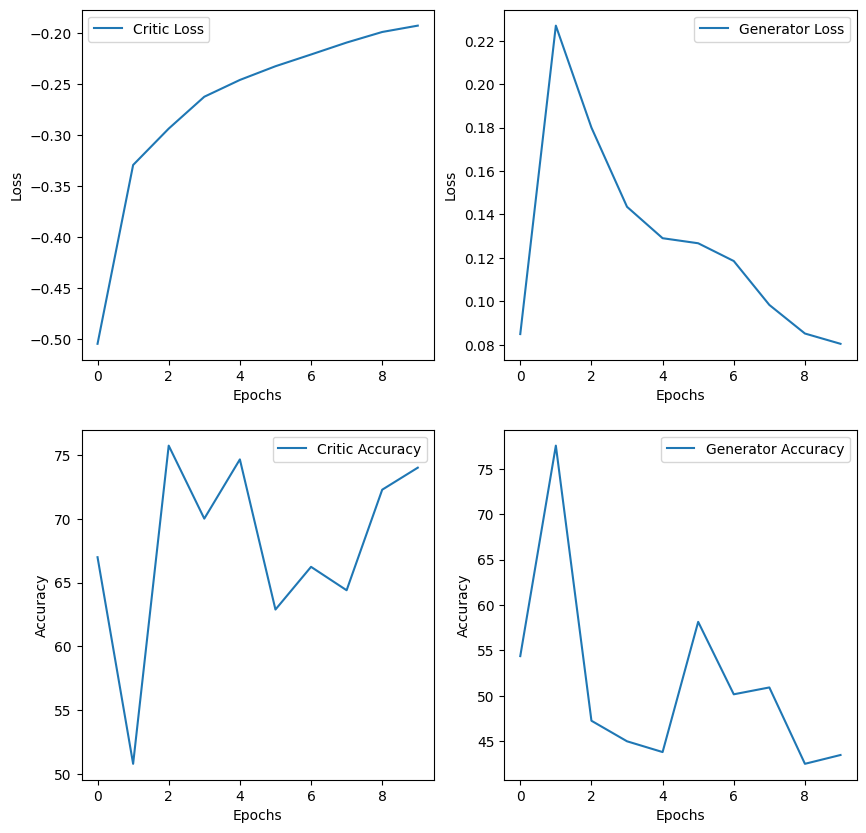

In [24]:
def plot_losses_and_accuracy(loss_history):
    epochs = len(loss_history.history['c_loss'])
    x = range(epochs)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    axs[0, 0].plot(x, loss_history.history['c_loss'], label="Critic Loss")
    axs[0, 0].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 0].legend()
    
    axs[0, 1].plot(x, loss_history.history['g_loss'], label="Generator Loss")
    axs[0, 1].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 1].legend()
    
    axs[1, 0].plot(x, loss_history.history['c_acc'], label="Critic Accuracy")
    axs[1, 0].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 0].legend()
    
    axs[1, 1].plot(x, loss_history.history['g_acc'], label="Generator Accuracy")
    axs[1, 1].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 1].legend()

    plt.show()

plot_losses_and_accuracy(loss_history)